# Predicting the price of a used car(SUV/Sedan) in Greater Cleveland area.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
%matplotlib inline

In [141]:
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("vehicles.csv")
pd.set_option('display.max_columns', None)
df.head()

,Id,Accidents,Body_type,Year,Fuel_economy_combined,Days_on_market,Rating,Distance,Color,Drivetrain,Engine,Make,Mileage,Model,Transmission,Additional_features,Previous_owners,Price_drops,Photos,Seats,Seller_type,Trim,Price
0,271936521,0,Sedan,2017,29 MPG,37,GREAT_PRICE,97.736984,BLACK,FRONT_WHEEL_DRIVE,I4,Chevrolet,49516,Sonic,Automatic,5,2,NaN,True,5,DEALER,LT Sedan FWD,7495.0
1,273738682,0,Sedan,2009,27 MPG,10,GREAT_PRICE,171.23712,SILVER,FRONT_WHEEL_DRIVE,I4,Chevrolet,132196,Malibu,Automatic,5,2,NaN,True,5,DEALER,LTZ FWD,3997.0
2,272560966,2,Sedan,2015,26 MPG,28,GREAT_PRICE,116.38247,BROWN,FRONT_WHEEL_DRIVE,I4,Chevrolet,20833,Impala,Automatic,6,1,NaN,True,5,DEALER,LTZ 1LZ FWD,15995.0
3,268734916,2,Sedan,2012,NaN,97,GREAT_PRICE,13.022558,BLACK,REAR_WHEEL_DRIVE,V6,Chevrolet,71347,Caprice,6-Speed Automatic,1,1,NaN,True,5,DEALER,Police Sedan RWD,5995.0
4,269505576,0,Sedan,2017,31 MPG,86,GREAT_PRICE,126.89147,SILVER,FRONT_WHEEL_DRIVE,I4,Chevrolet,31152,Malibu,6-Speed Automatic,4,1,NaN,True,5,DEALER,LT FWD,12925.0


In [4]:
df.shape

(19084, 23)

In [5]:
df.columns

Index(['Id', 'Accidents', 'Body_type', 'Year', 'Fuel_economy_combined',
       'Days_on_market', 'Rating', 'Distance', 'Color', 'Drivetrain', 'Engine',
       'Make', 'Mileage', 'Model', 'Transmission', 'Additional_features',
       'Previous_owners', 'Price_drops', 'Photos', 'Seats', 'Seller_type',
       'Trim', 'Price'],
      dtype='object')

In [6]:
df.describe()

,Id,Accidents,Body_type,Year,Fuel_economy_combined,Days_on_market,Rating,Distance,Color,Drivetrain,Engine,Make,Mileage,Model,Transmission,Additional_features,Previous_owners,Price_drops,Photos,Seats,Seller_type,Trim,Price
count,19084,19006,19070,19084,17001,19084,18597,19084,19084,18023,18831,19084,19036,19084,18882,19084,18779,2018,17744,18809,19084,18894,18786
unique,18463,7,3,18,38,523,7,2235,15,6,9,13,16796,163,32,25,9,2,2,7,3,756,6524
top,Id,0,SUV / Crossover,2017,29 MPG,4,FAIR_PRICE,180.90224,BLACK,FRONT_WHEEL_DRIVE,I4,Kia,Mileage,Sorento,6-Speed Automatic,3,1,True,True,5,DEALER,LX,7995.0
freq,22,15723,10327,4866,1502,458,9929,118,3525,9030,13496,2400,22,757,5526,4794,11904,1996,17722,15909,19000,935,152


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Id                     19084 non-null  object
 1   Accidents              19006 non-null  object
 2   Body_type              19070 non-null  object
 3   Year                   19084 non-null  object
 4   Fuel_economy_combined  17001 non-null  object
 5   Days_on_market         19084 non-null  object
 6   Rating                 18597 non-null  object
 7   Distance               19084 non-null  object
 8   Color                  19084 non-null  object
 9   Drivetrain             18023 non-null  object
 10  Engine                 18831 non-null  object
 11  Make                   19084 non-null  object
 12  Mileage                19036 non-null  object
 13  Model                  19084 non-null  object
 14  Transmission           18882 non-null  object
 15  Additional_features

### ID for each vehicle must be unique. Looks like we have a few duplicates

In [8]:
df["Id"].value_counts()

Id           22
268593059     2
272729237     2
272163888     2
273506580     2
             ..
252529672     1
268260686     1
247705001     1
265324606     1
274248474     1
Name: Id, Length: 18463, dtype: int64

 Looks like the labels also got scraped from each page!

In [9]:
df.drop(index = df[df["Id"] == "Id"].index,inplace=True)

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.dtypes

Id                       object
Accidents                object
Body_type                object
Year                     object
Fuel_economy_combined    object
Days_on_market           object
Rating                   object
Distance                 object
Color                    object
Drivetrain               object
Engine                   object
Make                     object
Mileage                  object
Model                    object
Transmission             object
Additional_features      object
Previous_owners          object
Price_drops              object
Photos                   object
Seats                    object
Seller_type              object
Trim                     object
Price                    object
dtype: object

### Some of them are numerical columns while some are categorical ones. We need to change the types before we could do any feature engineering. Pandas doesn't let us change the dtype to int when there are null values in the column. Let's change all the numerical columns to float type

Numerical feature Fuel_economy_combined has MPG at the end. Let's get rid of the MPG from the column

In [12]:
df["Fuel_economy_combined"]=df["Fuel_economy_combined"].str.replace("MPG","")

In [13]:
columns_to_float = ["Fuel_economy_combined","Accidents","Year","Days_on_market","Distance","Mileage",
                    "Additional_features","Previous_owners","Seats","Price"]

In [14]:
df[columns_to_float] = df[columns_to_float].astype(np.float)
# Use this instead

In [ ]:
#df["Fuel_economy_combined"] = df["Fuel_economy_combined"].astype(np.float)
#df["Accidents"] = df["Accidents"].astype(np.float)
#df["Year"] = df["Year"].astype(np.float)
#df["Days_on_market"] = df["Days_on_market"].astype(np.float)
#df["Distance"] = df["Distance"].astype(np.float)
#df["Mileage"] = df["Mileage"].astype(np.float)
#df["Additional_features"] = df["Additional_features"].astype(np.float)
#df["Previous_owners"] = df["Previous_owners"].astype(np.float)
#df["Seats"] = df["Seats"].astype(np.float)
#df["Price"] = df["Price"].astype(np.float)

In [15]:
df.dtypes

Id                        object
Accidents                float64
Body_type                 object
Year                     float64
Fuel_economy_combined    float64
Days_on_market           float64
Rating                    object
Distance                 float64
Color                     object
Drivetrain                object
Engine                    object
Make                      object
Mileage                  float64
Model                     object
Transmission              object
Additional_features      float64
Previous_owners          float64
Price_drops               object
Photos                    object
Seats                    float64
Seller_type               object
Trim                      object
Price                    float64
dtype: object

###  Missing values

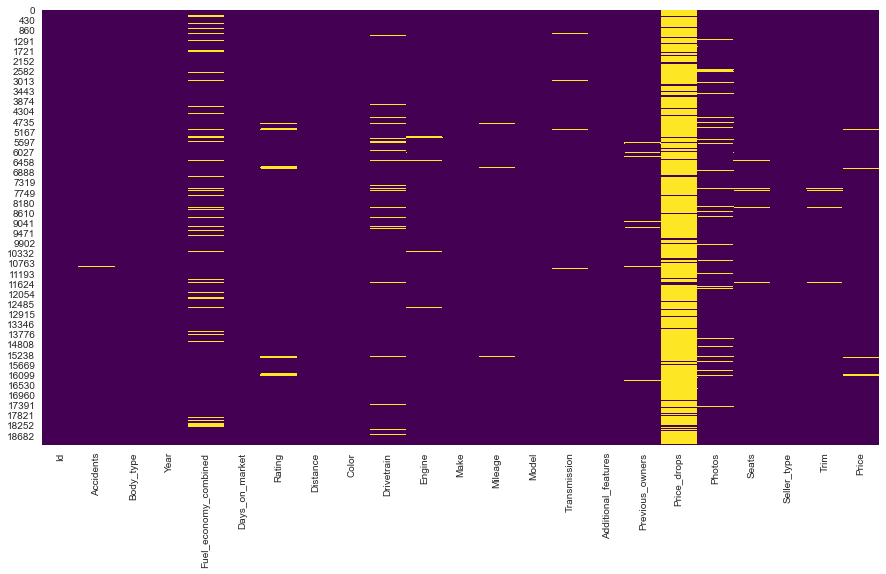

In [16]:
# Let's look at the missing values
plt.figure(figsize=(15,8))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [17]:
df.drop("Price_drops",axis=1,inplace=True) 

### Let's look at each of the columns and see how we can impute the missing values

In [18]:
missing = df.isnull().sum().sort_values(ascending=False)

In [19]:
missing/len(df)*100   # In terms of percentage

Fuel_economy_combined    10.887228
Photos                    7.057740
Drivetrain                5.644026
Rating                    2.637851
Price                     1.614126
Previous_owners           1.603293
Seats                     1.359549
Engine                    1.267468
Transmission              1.083306
Trim                      1.029141
Accidents                 0.411656
Mileage                   0.259994
Body_type                 0.075831
Model                     0.000000
Make                      0.000000
Color                     0.000000
Distance                  0.000000
Additional_features       0.000000
Days_on_market            0.000000
Seller_type               0.000000
Year                      0.000000
Id                        0.000000
dtype: float64

###  Fuel economy

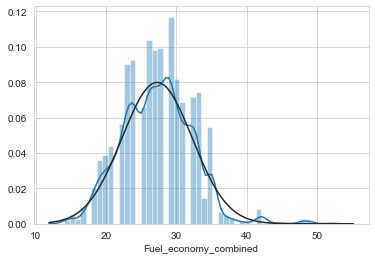

In [20]:
#Fuel economy
sns.distplot(df["Fuel_economy_combined"],fit = norm)

In [21]:
# Looks more or less normally distributed. We can impute the missing values with the mean
df["Fuel_economy_combined"].mean()

27.238208120593242

In [22]:
df['Fuel_economy_combined'].fillna(df["Fuel_economy_combined"].mean(),inplace = True)

### Photos

In [23]:
df["Photos"].fillna(0,inplace = True)

In [24]:
df["Photos"].replace("True",1,inplace=True)

###  Drivetrain

In [25]:
df["Drivetrain"].value_counts()

FRONT_WHEEL_DRIVE    8837
ALL_WHEEL_DRIVE      7077
FOUR_WHEEL_DRIVE     1465
REAR_WHEEL_DRIVE       24
FOUR_BY_TWO            17
Name: Drivetrain, dtype: int64

Four wheel drive is same as all wheel drive. Also, Four by Two is similar to FWD or RWD and switches in between.

In [26]:
df["Drivetrain"].replace("FOUR_WHEEL_DRIVE","ALL_WHEEL_DRIVE",inplace = True)
df["Drivetrain"].replace("FOUR_BY_TWO","FRONT_WHEEL_DRIVE",inplace = True)

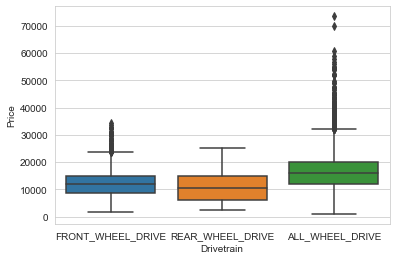

In [27]:
sns.boxplot(x = "Drivetrain",y ="Price",data =df)

In [28]:
#ok, that's why
df["Drivetrain"].replace("REAR_WHEEL_DRIVE","FRONT_WHEEL_DRIVE",inplace = True)

In [29]:
df["Drivetrain"].value_counts()

FRONT_WHEEL_DRIVE    8878
ALL_WHEEL_DRIVE      8542
Name: Drivetrain, dtype: int64

In [30]:
df["Drivetrain"].isnull().sum() #check for missing values

1042

In [31]:
df.groupby("Body_type")["Drivetrain"].value_counts() # See how does the drivetrain stack up against the bodytype

Body_type        Drivetrain       
SUV / Crossover  ALL_WHEEL_DRIVE      7498
                 FRONT_WHEEL_DRIVE    1668
Sedan            FRONT_WHEEL_DRIVE    7210
                 ALL_WHEEL_DRIVE      1044
Name: Drivetrain, dtype: int64

Looks like more SUVs have AWD while sedans predominantly have FWD.
So, let's impute the missing value with AWD when the bodytype is suv and FWD when sedan.

In [33]:
# Function to impute missing values in the drivetrain column based on the kind of bodytype
def impute_drive_train(columns):
    body_type = columns[0]
    drive_train = columns[1]
    if pd.isnull(drive_train):
        if body_type == "SUV / Crossover":
            return "ALL_WHEEL_DRIVE"
        else:
            return "FRONT_WHEEL_DRIVE"
    else:
        return drive_train    

In [34]:
df["Drivetrain"] = df[["Body_type","Drivetrain"]].apply(impute_drive_train,axis=1)

In [35]:
df["Drivetrain"].value_counts()  # No need for this line

FRONT_WHEEL_DRIVE    9359
ALL_WHEEL_DRIVE      9103
Name: Drivetrain, dtype: int64

###  Rating

In [36]:
# Rating
df["Rating"].value_counts()

FAIR_PRICE     9598
GOOD_PRICE     6606
GREAT_PRICE    1111
POOR_PRICE      519
OVERPRICED      114
OUTLIER          27
Name: Rating, dtype: int64

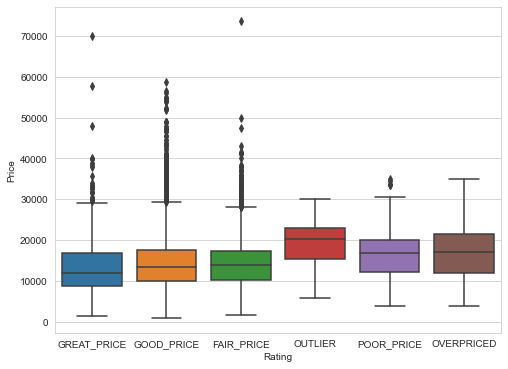

In [37]:
plt.figure(figsize=(8,6))
sns.boxplot(x = "Rating",y = "Price",data =df)

In [38]:
df["Rating"].replace(dict.fromkeys(["FAIR_PRICE","GOOD_PRICE","GREAT_PRICE"],"Great_Price"),inplace = True)
df["Rating"].replace(dict.fromkeys(["POOR_PRICE","OVERPRICED","OUTLIER"],"Poor_Price"),inplace = True)

In [39]:
df["Rating"].fillna("Great_Price",inplace=True)

###  Previous owners

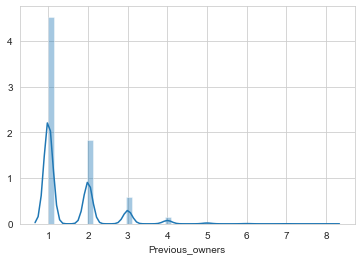

In [40]:
sns.distplot(df["Previous_owners"])

In [41]:
df["Previous_owners"].value_counts()

1.0    11522
2.0     4671
3.0     1485
4.0      371
5.0       86
6.0       24
7.0        6
8.0        1
Name: Previous_owners, dtype: int64

In [42]:
df["Previous_owners"].fillna(1.0,inplace=True)

## The rest of the columns have less than 2 % of missing values. Let's drop the rows with the missing values.

In [43]:
df.dropna(inplace=True)

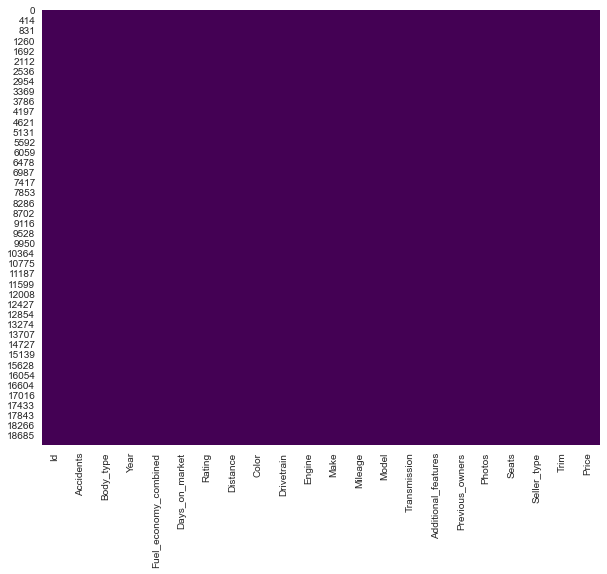

In [44]:
plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis') # Checking one more time for any missing value.

## Categorical features
* Engine
* Drivetrain : Done already!
* Transmission
* Trim
* Photos
* Rating : Done already!
* Color
* Make
* Model
* Bodytype

### Engine

In [45]:
# Engine
df["Engine"].value_counts()

I4    12493
V6     2952
H4     1635
V8      218
I5       75
I3       61
H6       40
I6        6
Name: Engine, dtype: int64

In [46]:
df["Engine"].replace(dict.fromkeys(["I3","I5","I4"],"I4"),inplace = True)
df["Engine"].replace(dict.fromkeys(["V6","V8","I6"],"V6"),inplace = True)
df["Engine"].replace(dict.fromkeys(["H4","H6"],"H4"),inplace = True)

### Transmission

In [47]:
df["Transmission"].value_counts()

6-Speed Automatic                     5111
Automatic                             5019
Continuously Variable Transmission    4039
6-Speed Automatic Overdrive            650
5-Speed Automatic                      608
8-Speed Automatic                      421
4-Speed Automatic                      336
9-Speed Automatic                      273
6-Speed Manual                         199
6-Speed Dual Clutch                    173
5-Speed Automatic Overdrive            167
5-Speed Manual                         121
Manual                                 102
7-Speed Automatic                       92
4-Speed Automatic Overdrive             43
7-Speed CVT                             37
6-Speed CVT                             18
6-Speed Manual Overdrive                15
9-Speed Automatic Overdrive             14
8-Speed CVT                              9
8-Speed Automatic Overdrive              7
5-Speed Manual Overdrive                 6
1-Speed Automatic                        4
1-Speed CVT

Lots of different names for the same kinds of transmission.
The three main categories are:
1. Automatic
2. Manual
3. Continuous Variable Transmission(CVT)

Let's create a mask for each of them

In [48]:
mask_automatic = df["Transmission"].value_counts().index.str.contains("Automatic",case=False,regex=False)
mask_manual = df["Transmission"].value_counts().index.str.contains("(Manual|Clutch)",case=False,regex=True)
mask_cvt = df["Transmission"].value_counts().index.str.contains("(Continuous|CVT)",case=False,regex=True)

/Users/axr524/anaconda2/envs/scrape_env/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [49]:
auto_list = df["Transmission"].value_counts().index[mask_automatic].tolist()
manual_list = df["Transmission"].value_counts().index[mask_manual].tolist()
cvt_list = df["Transmission"].value_counts().index[mask_cvt].tolist()

In [50]:
df["Transmission"].replace(dict.fromkeys(auto_list,"Automatic"),inplace = True)
df["Transmission"].replace(dict.fromkeys(manual_list,"Manual"),inplace = True)
df["Transmission"].replace(dict.fromkeys(cvt_list,"CVT"),inplace = True)

In [51]:
df["Transmission"].value_counts()

Automatic    12750
CVT           4107
Manual         623
Name: Transmission, dtype: int64

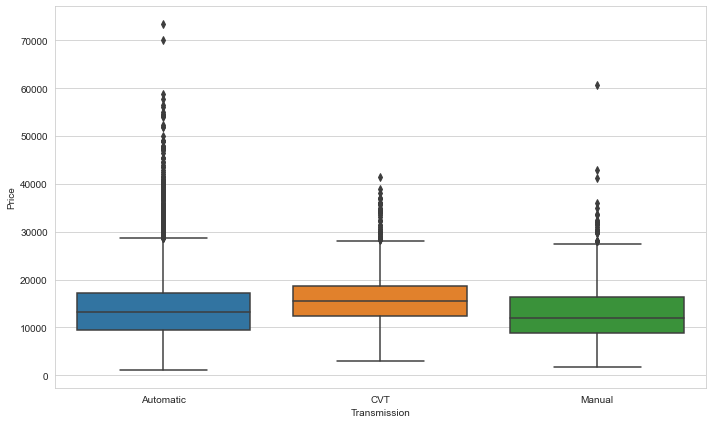

In [52]:
plt.figure(figsize=(10,6))
sns.boxplot(df["Transmission"],df["Price"])
plt.xticks(rotation=0)
plt.tight_layout()

### Seller type

In [53]:
df["Seller_type"].value_counts()

DEALER     17423
PRIVATE       57
Name: Seller_type, dtype: int64

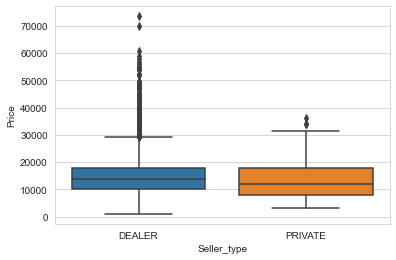

In [54]:
sns.boxplot(x = "Seller_type",y = "Price", data = df)

The spread of price when buying from a dealer is quite large which is expected. However, regardless of the other factors, a vehicle bought from a private party is almost always lower, interesting!

### Photos
Having photos on the website could potentially be a variable when it comes to the pricing. Let's see!

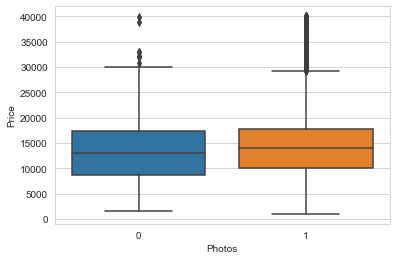

In [87]:
sns.boxplot(x = "Photos", y = "Price", data = df)

In [88]:
df.drop("Photos",axis=1,inplace=True)  # No useful information, let's drop it!

## Make, Model and Trim levels

### Make

In [55]:
df['Make'].value_counts()

Hyundai       1776
Chevrolet     1771
Honda         1757
Kia           1752
Ford          1729
Toyota        1715
Subaru        1675
Nissan        1674
Mazda         1219
Volkswagen     864
Jeep           861
Mitsubishi     687
Name: Make, dtype: int64

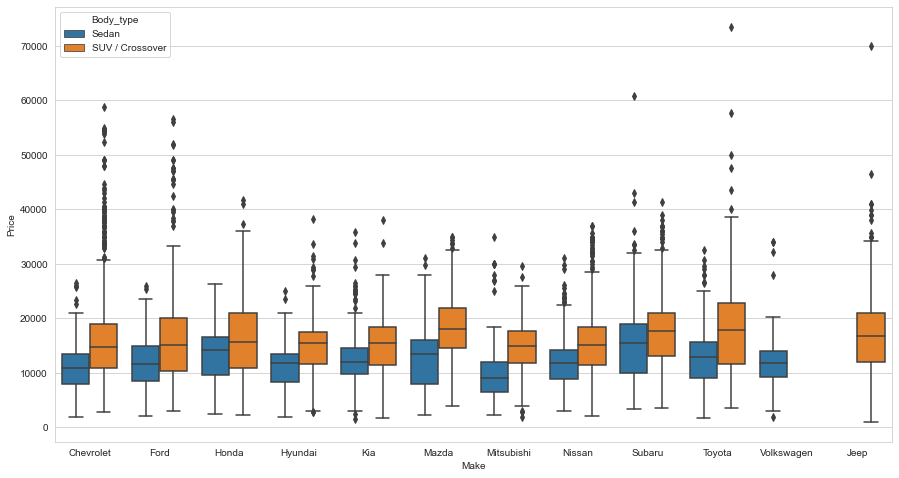

In [56]:
plt.figure(figsize=(15,8))
sns.boxplot(df["Make"],df["Price"],hue = df["Body_type"])

### Almost all the automakers are represented in both the sedan as well as the suv segment except Jeep which only builds suvs and Volkswagen which is known for building sedans.

### For almost all the makes, the respective SUVs tend to be slightly expensive as compared with their sedans.

In [57]:
plt.figure(figsize=(10,6))
df.groupby("Make")["Price"].mean().sort_values(ascending = False)

Make
Jeep          16982.505226
Subaru        16306.595224
Mazda         16191.030353
Toyota        15297.636735
Honda         14723.656801
Ford          13997.481781
Mitsubishi    13961.628821
Nissan        13691.411589
Chevrolet     13596.844720
Kia           13447.441210
Hyundai       12887.360360
Volkswagen    11639.137731
Name: Price, dtype: float64

<Figure size 720x432 with 0 Axes>

Except for Jeep and Volkswagen, the mean price for the rest of the automakers is hovering in the 13k to 16k mark.

Since Jeep sells suvs, it's obvious that the average price of their vehicles are the highest.
Similarly, Volkawagen is at the bottom because it sells only sedans.

Each carmaker has a trim level! We need to change it to numeric values so that we can make use of them.

### Trim levels

In [58]:
df["Trim_copy"] = df["Trim"].copy()

In [59]:
# Look for various trims across make
for make in df["Make"].unique():
    print("The make is: {} and the trims are: {}".format(make,df[df["Make"] == make]["Trim"].unique().tolist()))
    print("-"*115)

The make is: Chevrolet and the trims are: ['LT Sedan FWD', 'LTZ FWD', 'LTZ 1LZ FWD', 'Police Sedan RWD', 'LT FWD', 'LTZ 2LZ FWD', '1LT FWD', 'LS Sedan FWD', 'LS FWD', 'LT Diesel Sedan FWD', '2LT FWD', 'Premier Sedan FWD', 'LS Fleet FWD', '1LT Sedan FWD', 'Limited LT FWD', 'Premier FWD', 'Eco 1SA FWD', 'LTZ Sedan FWD', '2LT Sedan FWD', 'LT Fleet FWD', 'Diesel Sedan FWD', 'LT Fleet Sedan FWD', 'Limited LTZ FWD', 'LTZ 1LZ Sedan FWD', 'Limited LS FWD', '3LT FWD', 'L Sedan FWD', 'L FWD', 'FWD', 'Unmarked Police FWD', 'Eco Sedan FWD', '2LS Sedan FWD', 'RS Sedan FWD', 'LT AWD', 'LS AWD', 'Z71 4WD', '1LT AWD', 'LTZ AWD', '1.5T LT AWD', '2LT AWD', 'LTZ 4WD', 'LT 4WD', '1.5T LS AWD', 'Premier AWD', '1500 LT 4WD', '1.5T LT FWD', 'RS AWD', '1500 LS 4WD', '1500 LT RWD', '1.5T Premier AWD', '2.0T Premier AWD', '1.6T Diesel Premier FWD', '1500 LTZ RWD', 'LS 4WD', '1500 LTZ 4WD', 'LS Fleet 4WD', '2LS', 'LT', '2.0T LT AWD', '2.0T LT FWD', 'LT Cloth FWD', '3SS AWD', 'LT Leather AWD', 'RS FWD', '2LT 4WD'

## 3 levels of trims for each make

### Masks for each trim

In [60]:
mask_1 = df["Trim_copy"].value_counts().index.str.contains(
    "(LX|SportSi|Gx|L|LE|Sedan|Base|LS|RS|FWD|XLT|value|ES|SR|Latitude)",
    case=False,regex=True)   # Mask for base trim

/Users/axr524/anaconda2/envs/scrape_env/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [61]:
mask_2 = df["Trim_copy"].value_counts().index.str.contains(
    "(EX|Navigation|RES|SE|S|LT|Hybrid|SEL|ST|Signature|SX|SV|SL|Altitude)",
    case=False,regex=True) # Mask for mid trim

In [62]:
mask_3 = df["Trim_copy"].value_counts().index.str.contains(
    "(Touring|EX-T|Elite|XLE|XSE|Limited|Edition|Premier|Titanium|Luxury|Premium|Ultimate|Grand|GT|Platinum|GLI|2.0T|Trailhawk|Overland)",
    case=False,regex=True)  # Mask for high trim

### Some of the values are shared among the 3 masks

<img src="venn.png">

### Here, we're going to replace the trim levels with the respective numbers:
* Values that belong to 100: 1
* Values that belong to 010: 3
* Values that belong to 001: 5
* Values that belong to 110: 2 : Mean of 100 and 010
* Values that belong to 101: 3 : Mean of 100 and 001
* Values that belong to 001: 4 : Mean of 010 and 001
* Values that belong to 111: 3 : Mean of 100 and 101 and 001
* Values that belong to 000: 5 : These are usually the models which have fancy names and are mostly higher trim.

In [63]:
len(df["Trim_copy"].value_counts())   #Omega  # This sample space is divided into 8 parts.

738

In [64]:
len(df["Trim_copy"].value_counts().index[mask_1])  # Mask1

510

In [65]:
len(df["Trim_copy"].value_counts().index[mask_2]) # Mask2

486

In [66]:
len(df["Trim_copy"].value_counts().index[mask_3]) # Mask3

261

In [67]:
list_111 = df["Trim_copy"].value_counts().index[(mask_1)&(mask_2)&(mask_3)].tolist()        # 111
list_110 = df["Trim_copy"].value_counts().index[(~mask_3)&((mask_1)&(mask_2))].tolist()     # 110
list_101 = df["Trim_copy"].value_counts().index[(~mask_2)&((mask_1)&(mask_3))].tolist()     # 101
list_011 = df["Trim_copy"].value_counts().index[(~mask_1)&((mask_3)&(mask_2))].tolist()     # 011
list_100 = df["Trim_copy"].value_counts().index[(mask_1)&(~((mask_2)|(mask_3)))].tolist()   # 100
list_010 = df["Trim_copy"].value_counts().index[(mask_2)&(~((mask_1)|(mask_3)))].tolist()   # 010
list_001 = df["Trim_copy"].value_counts().index[(mask_3)&(~((mask_2)|(mask_1)))].tolist()   # 001
list_000 = df["Trim_copy"].value_counts().index[~((mask_1)|(mask_2)|(mask_3))].tolist()     # 000

In [68]:
df["Trim_copy"].replace(dict.fromkeys(list_100,1),inplace = True)
df["Trim_copy"].replace(dict.fromkeys(list_010,3),inplace = True)
df["Trim_copy"].replace(dict.fromkeys(list_001,5),inplace = True)
df["Trim_copy"].replace(dict.fromkeys(list_110,2),inplace = True)
df["Trim_copy"].replace(dict.fromkeys(list_101,3),inplace = True)
df["Trim_copy"].replace(dict.fromkeys(list_011,4),inplace = True)
df["Trim_copy"].replace(dict.fromkeys(list_111,3),inplace = True)
df["Trim_copy"].replace(dict.fromkeys(list_000,5),inplace = True)

In [69]:
df["Trim_copy"].value_counts()

3    6398
2    5789
1    2631
5    2525
4     137
Name: Trim_copy, dtype: int64

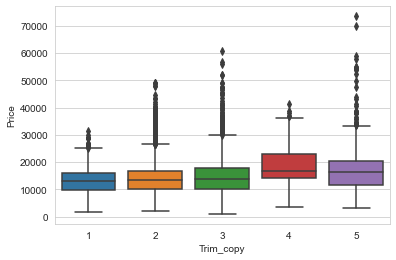

In [70]:
sns.boxplot(x = "Trim_copy", y = "Price", data = df)

In [71]:
df.groupby("Trim_copy")["Price"].mean().sort_values(ascending=False)

Trim_copy
4    18775.248175
5    16390.430099
3    14564.190059
2    13775.485403
1    12994.316990
Name: Price, dtype: float64

### Model
Usually there are three levels of size for each bodytype: sedan as well as suv.
And, for the same trim, the Price usually goes up with the level. Let's see!

In [86]:
for make in df["Make"].unique():
    print("The make is: {} and the models are: {}".format(make,df[df["Make"] == make]["Model"].unique().tolist()))
    print("-"*115)

The make is: Chevrolet and the models are: ['Sonic', 'Malibu', 'Impala', 'Caprice', 'Cruze', 'Cruze Limited', 'Impala Limited', 'Cobalt', 'Volt', 'Aveo', 'Equinox', 'Tahoe', 'Traverse', 'Trax', 'Blazer', 'Suburban', 'Trailblazer', 'Captiva Sport', 'Trailblazer EXT', 'Tahoe Hybrid']
-------------------------------------------------------------------------------------------------------------------
The make is: Ford and the models are: ['Fusion', 'Focus', 'Fusion Hybrid', 'Taurus', 'Fiesta', 'Fusion Energi', 'Escape', 'Explorer', 'Edge', 'Flex', 'Expedition', 'EcoSport', 'Taurus X']
-------------------------------------------------------------------------------------------------------------------
The make is: Honda and the models are: ['Civic', 'Accord', 'Insight', 'Accord Hybrid', 'Civic Hybrid', 'CR-V', 'HR-V', 'Pilot', 'Crosstour', 'Element', 'Accord Crosstour', 'Passport']
-----------------------------------------------------------------------------------------------------------------

### We'll have to use the same procedure which we used for the Trim levels.

In [89]:
mask_compact = df["Model"].value_counts().index.str.contains(
    "(Sonic|Cruze|Equinox|Volt|Trailblazer|Trax|Fiesta|Edge|EcoSport|Escape|Civic|HR-V|Element|Accent|Elantra|Kona|Tucson|Forte|Soul|Rio|Niro|Sportage|Seltos|Mazda3|CX-3|CX-30|Mirage|Lancer|Eclipse|Galant|Sentra|Versa|Rogue|Xterra|Juke|Kicks|Impreza|Crosstrek|Corolla|Yaris|C-HR|Jetta|Renegade|Compass)",
    case=False,regex=True)   # Mask for compact size

/Users/axr524/anaconda2/envs/scrape_env/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [90]:
mask_mid = df["Model"].value_counts().index.str.contains(
    "(Malibu|Traverse|Tahoe|Fusion|Explorer|Accord|Insight|CR-V|Passport|Sonata|Santa Fe|Optima|Sorento|Mazda6|CX-5|CX-7|Tribute|Outlander|Altima|Murano|Legacy|Forester|Outback|WRX|Tribeca|Camry|Rav-4|Highlander|4Runner|Passat|CC|Wrangler|Cherokee)",
    case=False,regex=True)   # Mask for mid size

In [91]:
mask_full = df["Model"].value_counts().index.str.contains(
    "(Impala|Suburban|Taurus|Flex|Expedition|Pilot|Palisade|Cadenza|Stinger|Telluride|CX-9|Endeavor|Montero|Maxima|Pathfinder|Armada|Ascent|Avalon|Land Cruiser|Sequoia|Cruiser|Arteon|Grand Cherokee)",
    case=False,regex=True)   # Mask for full size

In [131]:
df["Model_copy"] = df["Model"].copy()

In [132]:
model_list_111 = df["Model_copy"].value_counts().index[(mask_compact)&(mask_mid)&(mask_full)].tolist()        # 111
model_list_110 = df["Model_copy"].value_counts().index[(~mask_full)&((mask_compact)&(mask_mid))].tolist()     # 110
model_list_101 = df["Model_copy"].value_counts().index[(~mask_mid)&((mask_compact)&(mask_full))].tolist()     # 101
model_list_011 = df["Model_copy"].value_counts().index[(~mask_compact)&((mask_full)&(mask_mid))].tolist()     # 011
model_list_100 = df["Model_copy"].value_counts().index[(mask_compact)&(~((mask_mid)|(mask_full)))].tolist()   # 100
model_list_010 = df["Model_copy"].value_counts().index[(mask_mid)&(~((mask_compact)|(mask_full)))].tolist()   # 010
model_list_001 = df["Model_copy"].value_counts().index[(mask_full)&(~((mask_mid)|(mask_compact)))].tolist()   # 001
model_list_000 = df["Model_copy"].value_counts().index[~((mask_compact)|(mask_mid)|(mask_full))].tolist()     # 000

In [133]:
df["Model_copy"].replace(dict.fromkeys(model_list_100,1),inplace = True)
df["Model_copy"].replace(dict.fromkeys(model_list_010,3),inplace = True)
df["Model_copy"].replace(dict.fromkeys(model_list_001,5),inplace = True)
df["Model_copy"].replace(dict.fromkeys(model_list_110,3),inplace = True)
df["Model_copy"].replace(dict.fromkeys(model_list_101,3),inplace = True)
df["Model_copy"].replace(dict.fromkeys(model_list_011,4),inplace = True)
df["Model_copy"].replace(dict.fromkeys(model_list_111,3),inplace = True)
df["Model_copy"].replace(dict.fromkeys(model_list_000,2),inplace = True)

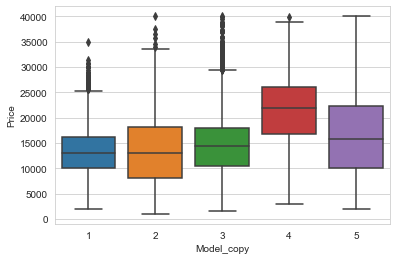

In [134]:
sns.boxplot(x="Model_copy",y = "Price", data = df)

### Color

In [72]:
df["Color"].value_counts()/len(df)*100

BLACK      18.529748
SILVER     16.744851
WHITE      15.331808
GRAY       14.073227
BLUE       11.195652
RED        10.783753
UNKNOWN     9.914188
BROWN       1.315789
GREEN       0.972540
GOLD        0.411899
ORANGE      0.314645
TEAL        0.274600
PURPLE      0.097254
YELLOW      0.040046
Name: Color, dtype: float64

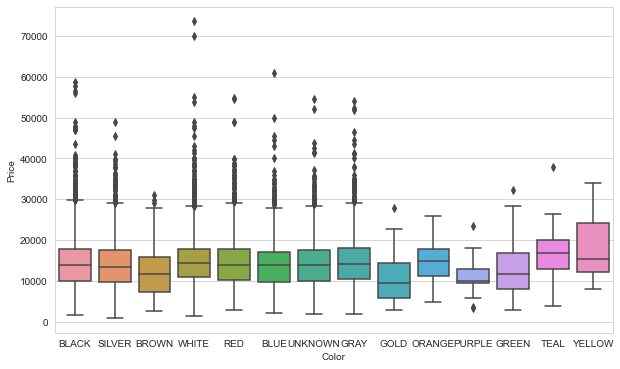

In [73]:
plt.figure(figsize=(10,6))
sns.boxplot(df["Color"],df["Price"])

## Color doesn't seem to affect the sales much here in our case.
## Let's drop it 

In [74]:
df.drop("Color",axis=1,inplace=True)

## Now on to the numerical features
* Accidents
* Year
* Fuel economy
* Distance
* Days on market
* Mileage
* Additional features (eg: heated seats, push-button start, etc.)
* Previous owners
* Seats

We'll analyze all of these features and see which ones affect the price the most.

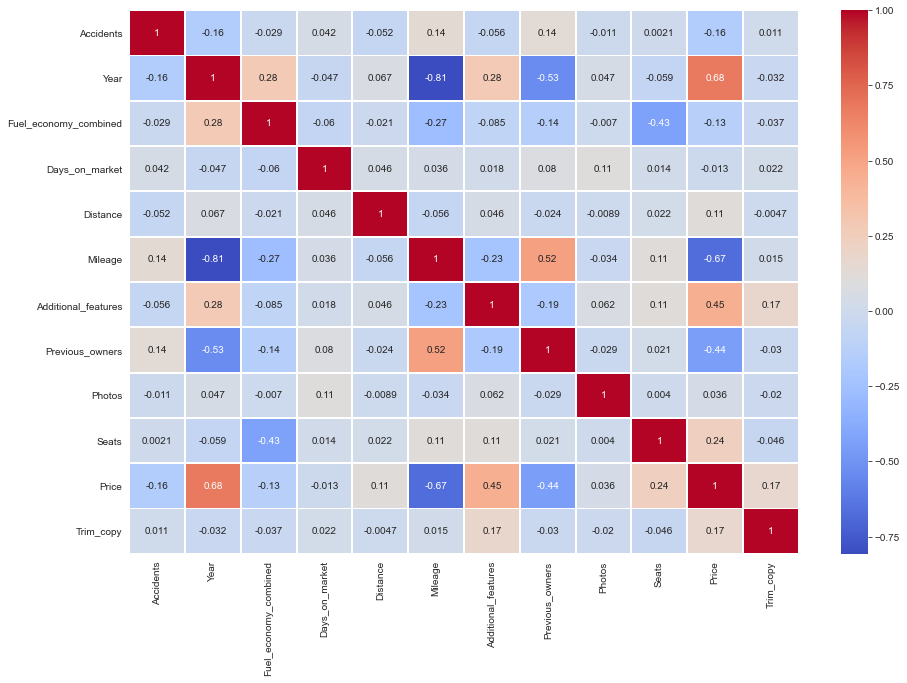

In [75]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(),annot=True,linewidths=1,cmap = "coolwarm")

In [76]:
df.corr()["Price"].sort_values(ascending = False) # Understand each of these blocks

Price                    1.000000
Year                     0.678290
Additional_features      0.447112
Seats                    0.240168
Trim_copy                0.167583
Distance                 0.111819
Photos                   0.035993
Days_on_market          -0.012846
Fuel_economy_combined   -0.130001
Accidents               -0.158132
Previous_owners         -0.441762
Mileage                 -0.670072
Name: Price, dtype: float64

## Price
### This is our target variable. 
It has positive strong correlation with some features while strongly negative with some. We'll drop the columns such as Distance and days on market since they don't really correlate with the Price column.

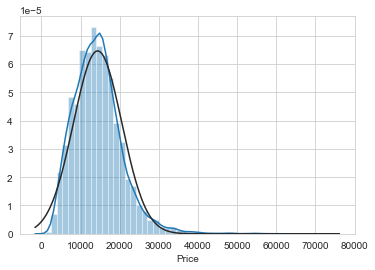

In [77]:
sns.distplot(df["Price"],fit=norm)

In [78]:
df["Price"].sort_values(ascending=False)

18666    73495.0
12462    69995.0
6723     60777.0
9442     58800.0
18185    57750.0
          ...   
140       1987.0
7564      1800.0
13252     1800.0
3670      1595.0
13076     1000.0
Name: Price, Length: 17480, dtype: float64

### Outliers

In [79]:
df.loc[df["Price"] > 40000]

,Id,Accidents,Body_type,Year,Fuel_economy_combined,Days_on_market,Rating,Distance,Drivetrain,Engine,Make,Mileage,Model,Transmission,Additional_features,Previous_owners,Photos,Seats,Seller_type,Trim,Price,Trim_copy
6567,266403647,0.0,Sedan,2018.0,19.000000,121.0,Great_Price,114.235290,ALL_WHEEL_DRIVE,H4,Subaru,10867.0,WRX STI,Manual,3.0,2.0,1,5.0,DEALER,Type RA AWD,41288.0,5
6648,249142526,0.0,Sedan,2018.0,19.000000,312.0,Great_Price,55.662600,ALL_WHEEL_DRIVE,H4,Subaru,7765.0,WRX STI,Manual,4.0,1.0,1,5.0,DEALER,Type RA AWD,42980.0,5
6723,270324045,0.0,Sedan,2019.0,27.238208,72.0,Great_Price,112.785126,ALL_WHEEL_DRIVE,H4,Subaru,3540.0,WRX STI,Manual,4.0,1.0,1,5.0,DEALER,S209 AWD,60777.0,3
8840,273844413,0.0,SUV / Crossover,2020.0,17.000000,9.0,Great_Price,180.902240,ALL_WHEEL_DRIVE,V6,Chevrolet,10675.0,Suburban,Automatic,7.0,1.0,1,8.0,DEALER,1500 LT 4WD,47998.0,2
8966,255437032,1.0,SUV / Crossover,2019.0,17.000000,247.0,Great_Price,104.687950,ALL_WHEEL_DRIVE,V6,Chevrolet,17208.0,Suburban,Automatic,7.0,1.0,1,8.0,DEALER,1500 LT 4WD,41995.0,2
9098,274457256,0.0,SUV / Crossover,2020.0,27.238208,1.0,Great_Price,180.902240,ALL_WHEEL_DRIVE,V6,Chevrolet,15653.0,Suburban,Automatic,8.0,1.0,1,8.0,DEALER,1500 LT 4WD,47998.0,2
9101,274083541,0.0,SUV / Crossover,2020.0,17.000000,6.0,Great_Price,180.902240,ALL_WHEEL_DRIVE,V6,Chevrolet,10903.0,Suburban,Automatic,7.0,1.0,1,8.0,DEALER,1500 LT 4WD,48998.0,2
9103,274457216,0.0,SUV / Crossover,2020.0,27.238208,1.0,Great_Price,180.902240,ALL_WHEEL_DRIVE,V6,Chevrolet,10940.0,Suburban,Automatic,7.0,2.0,1,8.0,DEALER,1500 LT 4WD,48998.0,2
9124,264777637,0.0,SUV / Crossover,2019.0,27.238208,140.0,Great_Price,139.752520,ALL_WHEEL_DRIVE,V6,Chevrolet,9830.0,Suburban,Automatic,13.0,1.0,1,8.0,DEALER,1500 Premier 4WD,54164.0,5
9161,273844393,0.0,SUV / Crossover,2020.0,17.000000,9.0,Great_Price,180.902240,ALL_WHEEL_DRIVE,V6,Chevrolet,11558.0,Suburban,Automatic,6.0,1.0,1,8.0,DEALER,1500 LT 4WD,48998.0,2


In [80]:
df.drop(index = df[df["Price"] > 40000].index, inplace=True)

### Additional features
More the features in a vehicle, the expensive it gets!

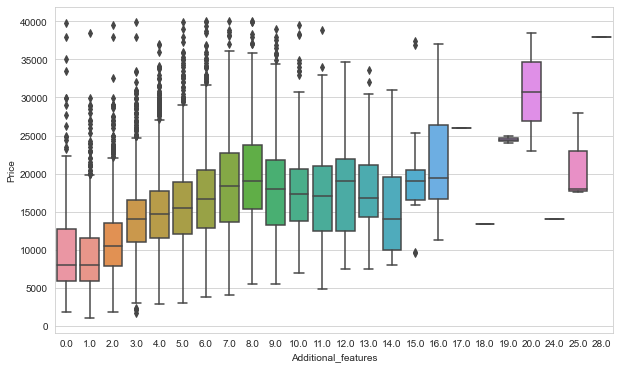

In [146]:
plt.figure(figsize=(10,6))
sns.boxplot(x = "Additional_features", y = "Price", data = df)

We do see an upward trend in the Price as the number of features increase.

### Seats

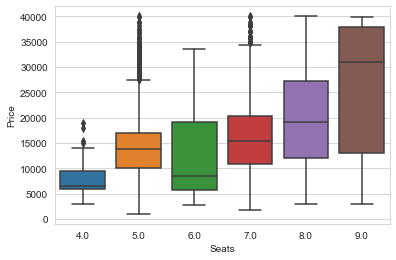

In [142]:
sns.boxplot(x = "Seats", y = "Price", data = df)

### Fuel economy

In [136]:
sns.set_style("white")

In [139]:
df.groupby("Body_type")["Fuel_economy_combined"].mean()

Body_type
SUV / Crossover    24.695620
Sedan              30.181195
Name: Fuel_economy_combined, dtype: float64

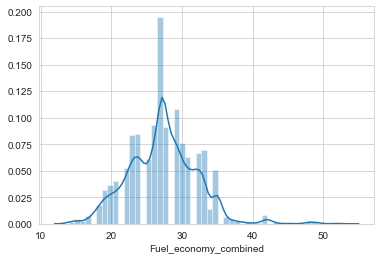

In [135]:
sns.distplot(df["Fuel_economy_combined"])

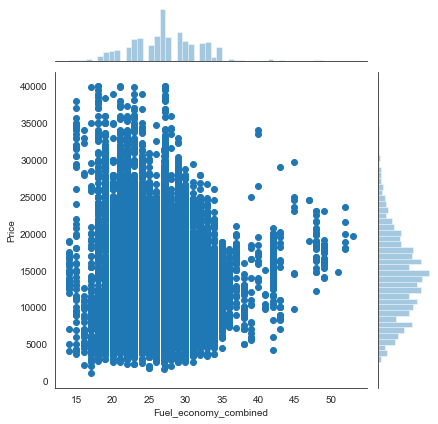

In [137]:
sns.jointplot(df["Fuel_economy_combined"],df["Price"])

This is interesting! Contrary to my initial thought that vehicles with low fuel economy must be cheaper to buy,  the opposite is true! Actually, the bigger cars with additional features tend to have low fuel economy and are usually expensive.

### Accidents and Previous owners
With the number of the accidents and previous owners, the value of the vehicle depreciates quickly. Let's see!

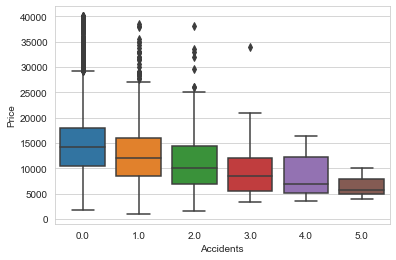

In [143]:
sns.boxplot(x = "Accidents", y = "Price", data = df)

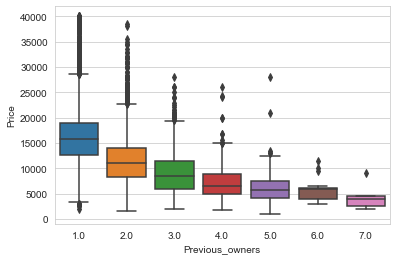

In [144]:
sns.boxplot(x = "Previous_owners", y = "Price", data = df)

### Mileage
The value of the vehicle should go down with mileage!

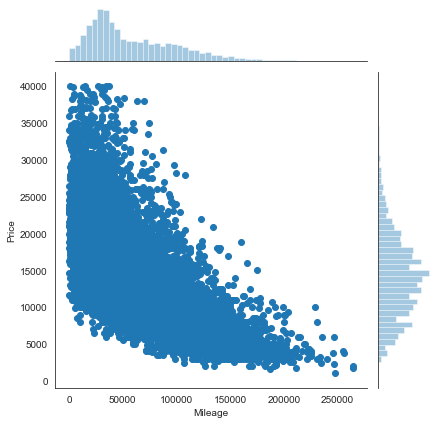

In [138]:
sns.jointplot(df["Mileage"],df["Price"])